# Comparação entre modelos vencedores para a ESN e subsistema N

## Bibliotecas

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import pickle

import time

import matplotlib.pyplot as plt
from scipy.stats import wilcoxon
import seaborn as sns
import os
import shutil
import copy

from torchesn.nn import ESN
from torchesn import utils

In [2]:
subsistema = 'N'

## Importando os dados

In [3]:
dados_treinamento = pd.read_csv(f'../../Preprocessamento/{subsistema}_treinamento.csv', index_col='DataHora')
dados_treinamento.index = pd.to_datetime(dados_treinamento.index, format="%Y-%m-%d %H:%M:%S")
dados_treinamento

,Carga,Temperatura,seg,ter,qua,qui,sex,sab,dom,seno_dia_semana,...,mai,jun,jul,ago,set,out,nov,dez,seno_mes,cosseno_mes
DataHora,,,,,,,,,,,,,,,,,,,,,
2018-01-03 00:00:00,-0.463425,-0.226717,0,0,1,0,0,0,0,0.974928,...,0,0,0,0,0,0,0,0,5.000000e-01,0.866025
2018-01-03 01:00:00,-0.473038,-0.226717,0,0,1,0,0,0,0,0.974928,...,0,0,0,0,0,0,0,0,5.000000e-01,0.866025
2018-01-03 02:00:00,-0.511504,-0.258305,0,0,1,0,0,0,0,0.974928,...,0,0,0,0,0,0,0,0,5.000000e-01,0.866025
2018-01-03 03:00:00,-0.536532,-0.287854,0,0,1,0,0,0,0,0.974928,...,0,0,0,0,0,0,0,0,5.000000e-01,0.866025
2018-01-03 04:00:00,-0.560466,-0.301101,0,0,1,0,0,0,0,0.974928,...,0,0,0,0,0,0,0,0,5.000000e-01,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,-0.307824,-0.153352,0,0,0,0,0,0,1,-0.781831,...,0,0,0,0,0,0,0,1,-2.449294e-16,1.000000
2023-12-31 20:00:00,-0.199531,-0.151314,0,0,0,0,0,0,1,-0.781831,...,0,0,0,0,0,0,0,1,-2.449294e-16,1.000000
2023-12-31 21:00:00,-0.184359,-0.196148,0,0,0,0,0,0,1,-0.781831,...,0,0,0,0,0,0,0,1,-2.449294e-16,1.000000


In [4]:
dados_treinamento_2019 = dados_treinamento[dados_treinamento.index.year != 2018]
dados_treinamento_2020 = dados_treinamento_2019[dados_treinamento_2019.index.year != 2019]
dados_treinamento_2021 = dados_treinamento_2020[dados_treinamento_2020.index.year != 2020]
dados_treinamento_2022 = dados_treinamento_2021[dados_treinamento_2021.index.year != 2021]
dados_treinamento_2023 = dados_treinamento_2022[dados_treinamento_2022.index.year != 2022]

In [5]:
dados_validacao = pd.read_csv(f'../../Preprocessamento/{subsistema}_validacao.csv', index_col='DataHora')
dados_validacao.index = pd.to_datetime(dados_validacao.index, format="%Y-%m-%d %H:%M:%S")
dados_validacao

,Carga,Temperatura,seg,ter,qua,qui,sex,sab,dom,seno_dia_semana,...,mai,jun,jul,ago,set,out,nov,dez,seno_mes,cosseno_mes
DataHora,,,,,,,,,,,,,,,,,,,,,
2023-12-30 00:00:00,-0.000783,-0.185959,0,0,0,0,0,1,0,-0.974928,...,0,0,0,0,0,0,0,1,-2.449294e-16,1.0
2023-12-30 01:00:00,-0.011805,-0.170675,0,0,0,0,0,1,0,-0.974928,...,0,0,0,0,0,0,0,1,-2.449294e-16,1.0
2023-12-30 02:00:00,-0.026000,-0.183921,0,0,0,0,0,1,0,-0.974928,...,0,0,0,0,0,0,0,1,-2.449294e-16,1.0
2023-12-30 03:00:00,-0.060026,-0.183921,0,0,0,0,0,1,0,-0.974928,...,0,0,0,0,0,0,0,1,-2.449294e-16,1.0
2023-12-30 04:00:00,-0.094685,-0.183921,0,0,0,0,0,1,0,-0.974928,...,0,0,0,0,0,0,0,1,-2.449294e-16,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-31 19:00:00,0.071314,-0.045343,0,1,0,0,0,0,0,0.781831,...,0,0,0,0,0,0,0,1,-2.449294e-16,1.0
2024-12-31 20:00:00,0.050805,-0.106481,0,1,0,0,0,0,0,0.781831,...,0,0,0,0,0,0,0,1,-2.449294e-16,1.0
2024-12-31 21:00:00,0.090677,-0.138068,0,1,0,0,0,0,0,0.781831,...,0,0,0,0,0,0,0,1,-2.449294e-16,1.0


## Criando os datasets

In [ ]:
class Dados(Dataset):
    def __init__(self, dados, modelo, entrada_carga = 48, horas_de_previsao = 24, horizonte = 2):
        # Recebendo e tratando os dados
        self.dados = dados

        # Pega dados de carga
        self.carga = self.dados['Carga']

        # Pega dados de temperatura
        self.temperatura = self.dados['Temperatura']
        
        # Pega dados de dia da semana no formato sen cos
        self.lista_dias_semana_S = list(self.dados.columns[2:4])
        self.dias_semana_S = self.dados[self.lista_dias_semana_S]

        # Pega dados de mes no formato sen cos
        self.lista_mes_S = list(self.dados.columns[4:])
        self.meses_S = self.dados[self.lista_mes_S]

        # Configurando outras variaveis
        self.entrada_carga = 48
        self.horas_de_previsao = horas_de_previsao
        self.horizonte = horizonte

        # Separa os dados
        self.entrada = []
        self.previsao = []
        for idx in range((len(self.carga) // 24) - self.entrada_carga // 24 - self.horizonte + 1):
            # Pula dia a dia
            idx = idx * 24
            
            # Salva o historico de carga
            carga_hist = self.carga[idx: idx + self.entrada_carga]

            # Salva os dados de temperatura do dia da previsão
            temperatura_H = self.temperatura[idx + self.entrada_carga + (self.horizonte - 1) * 24 : idx + self.entrada_carga + (self.horizonte) * 24]

            # Salva os dados de temperatura mínima, media e máxima
            temperatura_P = pd.Series([temperatura_H.min(), temperatura_H.mean(), temperatura_H.max()])
            
            # Salva os dados de dia da semana no formato sen cos
            dia_S = self.dias_semana_S.iloc[idx + self.entrada_carga + (self.horizonte - 1) * 24]

            # Salva os dados de mes no formato sen cos
            mes_S = self.meses_S.iloc[idx + self.entrada_carga + (self.horizonte - 1) * 24]

            # Gera as entradas concatenando os dados
            if modelo == 'M1_1':
                previsor_concat = pd.concat([carga_hist]).values
            elif modelo == 'M2_1':
                previsor_concat = pd.concat([carga_hist, temperatura_H]).values
            elif modelo == 'M2_2':
                previsor_concat = pd.concat([carga_hist, temperatura_P]).values
            elif modelo == 'M2_3':
                previsor_concat = pd.concat([carga_hist, dia_S]).values
            elif modelo == 'M2_4':
                previsor_concat = pd.concat([carga_hist, mes_S]).values
            elif modelo == 'M3_1':
                previsor_concat = pd.concat([carga_hist, temperatura_H, dia_S]).values
            elif modelo == 'M3_2':
                previsor_concat = pd.concat([carga_hist, temperatura_H, mes_S]).values
            elif modelo == 'M3_3':
                previsor_concat = pd.concat([carga_hist, temperatura_P, dia_S]).values
            elif modelo == 'M3_4':
                previsor_concat = pd.concat([carga_hist, temperatura_P, mes_S]).values
            elif modelo == 'M3_5':
                previsor_concat = pd.concat([carga_hist, dia_S, mes_S]).values
            elif modelo == 'M4_1':
                previsor_concat = pd.concat([carga_hist, temperatura_H, dia_S, mes_S]).values
            elif modelo == 'M4_2':
                previsor_concat = pd.concat([carga_hist, temperatura_P, dia_S, mes_S]).values
                
            self.entrada.append(previsor_concat)

            # Gera os dados de saida
            saida_carga = self.carga[idx + self.entrada_carga + (self.horizonte - 1) * 24 : idx + self.entrada_carga + (self.horizonte) * 24]
            self.previsao.append(saida_carga)
            
        self.entrada = torch.tensor(np.array(self.entrada), dtype = torch.float32)
        self.previsao = torch.tensor(np.array(self.previsao), dtype = torch.float32)

    def __len__(self):
        return (len(self.carga) // 24) - self.entrada_carga // 24 - self.horizonte + 1

    def __getitem__(self, idx):
        return self.entrada[idx], self.previsao[idx]

## Função treinar e classe AG

In [ ]:
def treinar(params):
    pass

In [11]:
class AG:
    def __init__(self, limites, tamanho_populacao, geracoes, taxa_mutacao, funcao_custo):
        self.limites = limites
        self.numero_variaveis = len(self.limites)
        self.tamanho_populacao = tamanho_populacao
        self.geracoes = geracoes
        self.taxa_mutacao = taxa_mutacao
        self.funcao_custo = funcao_custo
        self.geracao_atual = 0

        intervalos = [range(a, b+1) for a, b in limites]
        possibilidades = [comb for comb in product(*intervalos)]
        self.dic_historico = {(possibilidade): [] for possibilidade in possibilidades}

        self.populacao = []

    def criar_individuo(self):
        return [round(random.uniform(a - 0.49, b + 0.49)) for (a, b) in self.limites]

    def criar_populacao(self):
        return [self.criar_individuo() for _ in range(self.tamanho_populacao)]

    def avaliar_fitness(self):
        custos = []
        for ind in self.populacao:
            chave = tuple(ind)
            if self.dic_historico[chave]:
                print(f'Indivíduo já avaliado.')
                custos.append(self.dic_historico[chave][0])
            else:
                fit = self.funcao_custo(ind)
                custos.append(fit)
                self.dic_historico[chave].append(fit)
            print(f'Indivíduo: {ind}. Fit: {custos[-1]}')
        self.fitness = [1 / (1 + c) for c in custos]

    def selecao_roleta(self):
        soma = sum(self.fitness)
        pick = random.uniform(0, soma)
        atual = 0
        for ind, fit in zip(self.populacao, self.fitness):
            atual += fit
            if atual > pick:
                return ind
        return self.populacao[-1]

    def cruzamento(self, pai1, pai2):
        n = len(pai1)
        indices_pai1 = random.sample(range(n), k=n//2)
        filho = [pai1[i] if i in indices_pai1 else pai2[i] for i in range(n)]
        return filho

    def mutacao(self, ind):
        for i in range(self.numero_variaveis):
            if random.random() < self.taxa_mutacao:
                a, b = self.limites[i]
                ind[i] = round(random.uniform(a - 0.49, b + 0.49))
        return ind

    def salvar(self, nome_arquivo='ag_estado.pkl'):
        with open(nome_arquivo, 'wb') as f:
            pickle.dump(self, f)
        print(f"Estado salvo em '{nome_arquivo}'.")

    @staticmethod
    def carregar(nome_arquivo='ag_estado.pkl'):
        with open(nome_arquivo, 'rb') as f:
            ag = pickle.load(f)
        print(f"Estado carregado de '{nome_arquivo}'.")
        return ag

    def algoritmo_genetico(self, continuar=False):
        if not continuar or not self.populacao:
            self.populacao = self.criar_populacao()

        for geracao in range(self.geracao_atual, self.geracoes):
            print(f'\nGeração {geracao + 1}')
            self.avaliar_fitness()

            # Elitismo de 2 melhores
            indices_melhores = sorted(range(len(self.fitness)), key=lambda i: self.fitness[i], reverse=True)[:2]
            elite = [self.populacao[i] for i in indices_melhores]
            nova_pop = elite[:]

            while len(nova_pop) < self.tamanho_populacao:
                pai1 = self.selecao_roleta()
                pai2 = self.selecao_roleta()
                filho = self.cruzamento(pai1, pai2)
                filho = self.mutacao(filho)
                nova_pop.append(filho)

            self.populacao = nova_pop
            print(f"Elite: {elite}")

            # Salvar estado atual
            self.salvar()
            self.geracao_atual += 1

## Definição das melhores configurações

In [12]:
with open("ag_estado.pkl", "rb") as f:
    ag = pickle.load(f)

In [13]:
configuracao_1 = []
valor_1 = np.inf
configuracao_2 = []
valor_2 = np.inf
for configuracao in ag.dic_historico:
    if len(ag.dic_historico[configuracao]) > 0:
        if len(configuracao_1) == 0:
            configuracao_1 = configuracao
            valor_1 = ag.dic_historico[configuracao][0]
        elif len(configuracao_2) == 0:
            configuracao_2 = configuracao
            valor_2 = ag.dic_historico[configuracao][0]
        elif ag.dic_historico[configuracao][0] < valor_1:
            configuracao_2 = configuracao_1
            valor_2 = valor_1
            configuracao_1 = configuracao
            valor_1 = ag.dic_historico[configuracao][0]
        elif ag.dic_historico[configuracao][0] < valor_2:
            configuracao_2 = configuracao
            valor_2 = ag.dic_historico[configuracao][0]
print(configuracao_1, valor_1, configuracao_2, valor_2)

(5, 0, 2, 1, 1, 0, 2) 0.007964864326640963 (3, 0, 2, 0, 0, 2, 2) 0.00923039335757494


## Função de treinamento das configurações finalistas

In [ ]:
def treinamento_finalistas(configuracao, conf_id):
    # DEFINIÇÕES DE PASTAS
    base_dir = f"conf_{conf_id}"
    os.makedirs(base_dir, exist_ok=True)

    # CONFIGURAÇÕES
    modelo_entrada, n_neuronios, ano_entrada, otm, washout, r_espectral, t_vazamento = configuracao

    lista_modelo_entrada = (
        [f"M1_{i}" for i in range(1, 2)] +
        [f"M2_{i}" for i in range(1, 5)] +
        [f"M3_{i}" for i in range(1, 6)] + 
        [f"M4_{i}" for i in range(1, 3)]
    )
    lista_modelo_n_entradas = [
        48,
        48+24, 48+3, 48+2, 48+2,
        48+24+2, 48+24+2,
        48+3+2, 48+3+2,
        48+2+2,
        48+24+2+2, 48+3+2+2
    ]
    n_entradas = lista_modelo_n_entradas[modelo_entrada]
    modelo_entrada = lista_modelo_entrada[modelo_entrada]
    lista_n_neuronios = [
        24,
        round(0.25*(2*n_entradas-24)+24),
        round(0.5*(2*n_entradas-24)+24),
        round(0.75*(2*n_entradas-24)+24),
        2*n_entradas
    ]
    n_neuronios = lista_n_neuronios[n_neuronios]
    lista_ano_entrada = [2018, 2020, 2022]
    ano_entrada = lista_ano_entrada[ano_entrada]

    lista_otm = ['svd', 'inv']
    otm = lista_otm[otm]

    lista_washout = [0.05, 0.1, 0.2]
    washout = lista_washout[washout]

    lista_r_espectral = [0.8, 0.9, 0.99]
    r_espectral = lista_r_espectral[r_espectral]

    lista_t_vazamento = [0.05, 0.1, 0.3]
    t_vazamento = lista_t_vazamento[t_vazamento]

    num_seeds = 50
    n_earlystop = 25

    lista_melhor_loss = []
    tempos_treinamento = []

    melhor_loss_global = np.inf
    melhor_modelo_path = None

    # LOOP DAS SEEDS
    for seed in range(1, num_seeds + 1):
        torch.manual_seed(seed)
        np.random.seed(seed)

        inicio_seed = time.perf_counter()

        # Dados
        if ano_entrada == 2018:
            treinamento_dataset = Dados(dados_treinamento, modelo_entrada)
        elif ano_entrada == 2020:
            treinamento_dataset = Dados(dados_treinamento_2020, modelo_entrada)
        elif ano_entrada == 2022:
            treinamento_dataset = Dados(dados_treinamento_2022, modelo_entrada)

        treinamento_dataloader = DataLoader(
            treinamento_dataset,
            batch_size=len(treinamento_dataset),
            shuffle=False
        )

        validacao_dataset = Dados(dados_validacao, modelo_entrada)
        validacao_dataloader = DataLoader(
            validacao_dataset,
            batch_size=len(validacao_dataset),
            shuffle=False
        )

        # Rede
        rede = ESN(
            input_size=n_entradas,
            hidden_size=n_neuronios,
            output_size=24,
            readout_training = otm,
            nonlinearity = 'tanh',
            spectral_radius = r_espectral,
            leaking_rate = t_vazamento
        )

        criterio = nn.MSELoss()

        melhor_perda_validacao = np.inf
        melhor_state_dict = None

        # TREINAMENTO
        for entrada_b, saida_b in treinamento_dataloader:
            entrada_treinamento = entrada_b.unsqueeze(1) 
            saida_treinamento = saida_b.unsqueeze(1) 

        w = [int(washout * len(treinamento_dataset))]

        y_flat = utils.prepare_target(
            saida_treinamento,
            [len(treinamento_dataset)],
            w
        )

        # Acumula estatísticas do readout
        rede(entrada_treinamento, w, None, y_flat)
        rede.fit()
        _, hidden_train = rede(entrada_treinamento, w)

        rede.eval()
        with torch.no_grad():
            for entrada_b, saida_b in validacao_dataloader:
                entrada_validacao = entrada_b.unsqueeze(1)
                saida_validacao = saida_b.unsqueeze(1)

                previsao, _ = rede(entrada_validacao, [0], hidden_train)

                previsao = previsao.squeeze(0)
                saida_validacao = saida_validacao.squeeze(0)

                perda = criterio(previsao, saida_validacao).item()

                if perda < melhor_perda_validacao:
                    melhor_perda_validacao = perda
                    melhor_state_dict = copy.deepcopy(rede.state_dict())
                    melhor_h_final = hidden_train.clone()

                

        fim_seed = time.perf_counter()
        tempo_seed = fim_seed - inicio_seed

        tempos_treinamento.append(tempo_seed)
        lista_melhor_loss.append(melhor_perda_validacao)
        # SALVAR MODELO DA SEED
        model_path = os.path.join(
            base_dir,
            f"modelo_seed_{seed:02d}_loss_{melhor_perda_validacao:.6f}.pt"
        )

        torch.save({
            "seed": seed,
            "val_loss": melhor_perda_validacao,
            "tempo_treinamento_seg": tempo_seed,
            "configuracao": configuracao,
            "state_dict": melhor_state_dict,
            "h_final": melhor_h_final,
            "washout": w
        }, model_path)


        # ATUALIZAR MELHOR MODELO GLOBAL
        if melhor_perda_validacao < melhor_loss_global:
            melhor_loss_global = melhor_perda_validacao
            melhor_modelo_path = model_path

        print(
            f"Seed {seed:02d} | "
            f"Loss val: {melhor_perda_validacao:.6f} | "
            f"Tempo: {tempo_seed:.2f} s"
        )

    # COPIA O MELHOR MODELO
    if melhor_modelo_path is not None:
        melhor_path_final = os.path.join(base_dir, "MELHOR_MODELO.pt")
        shutil.copy2(melhor_modelo_path, melhor_path_final)

    # ESTATÍSTICAS DE TEMPO
    tempo_medio = np.mean(tempos_treinamento)
    tempo_std = np.std(tempos_treinamento)

    print("\nTempo de Treinamento")
    print(f"Tempo médio por seed: {tempo_medio:.2f} s")
    print(f"Desvio padrão: {tempo_std:.2f} s")

    return lista_melhor_loss, tempos_treinamento


## Treinamento das configurações finalistas

In [15]:
loss_configuracao_1, tempos_treinamento_1 = treinamento_finalistas(configuracao_1, '1')

Seed 01 | Loss val: 0.030567 | Tempo: 0.32 s
Seed 02 | Loss val: 0.022144 | Tempo: 0.34 s
Seed 03 | Loss val: 0.034587 | Tempo: 0.31 s
Seed 04 | Loss val: 0.028449 | Tempo: 0.31 s
Seed 05 | Loss val: 0.068810 | Tempo: 0.45 s
Seed 06 | Loss val: 0.009190 | Tempo: 0.35 s
Seed 07 | Loss val: 0.007036 | Tempo: 0.36 s
Seed 08 | Loss val: 0.014970 | Tempo: 0.34 s
Seed 09 | Loss val: 0.010022 | Tempo: 0.36 s
Seed 10 | Loss val: 0.007674 | Tempo: 0.32 s
Seed 11 | Loss val: 0.010110 | Tempo: 0.39 s
Seed 12 | Loss val: 0.008078 | Tempo: 0.32 s
Seed 13 | Loss val: 0.007032 | Tempo: 0.32 s
Seed 14 | Loss val: 0.004607 | Tempo: 0.33 s
Seed 15 | Loss val: 0.009194 | Tempo: 0.31 s
Seed 16 | Loss val: 0.006430 | Tempo: 0.30 s
Seed 17 | Loss val: 0.008108 | Tempo: 0.38 s
Seed 18 | Loss val: 0.006290 | Tempo: 0.31 s
Seed 19 | Loss val: 0.011365 | Tempo: 0.31 s
Seed 20 | Loss val: 0.019961 | Tempo: 0.31 s
Seed 21 | Loss val: 0.011665 | Tempo: 0.31 s
Seed 22 | Loss val: 0.004694 | Tempo: 0.31 s
Seed 23 | 

In [16]:
loss_configuracao_2, tempos_treinamento_2  = treinamento_finalistas(configuracao_2, '2')

Seed 01 | Loss val: 0.007268 | Tempo: 0.36 s
Seed 02 | Loss val: 0.012328 | Tempo: 0.28 s
Seed 03 | Loss val: 0.029586 | Tempo: 0.29 s
Seed 04 | Loss val: 0.005584 | Tempo: 0.28 s
Seed 05 | Loss val: 0.005240 | Tempo: 0.28 s
Seed 06 | Loss val: 0.036756 | Tempo: 0.28 s
Seed 07 | Loss val: 0.006007 | Tempo: 0.37 s
Seed 08 | Loss val: 0.010626 | Tempo: 0.28 s
Seed 09 | Loss val: 0.007636 | Tempo: 0.30 s
Seed 10 | Loss val: 0.006164 | Tempo: 0.30 s
Seed 11 | Loss val: 0.006560 | Tempo: 0.29 s
Seed 12 | Loss val: 0.008237 | Tempo: 0.36 s
Seed 13 | Loss val: 0.010341 | Tempo: 0.30 s
Seed 14 | Loss val: 0.005738 | Tempo: 0.30 s
Seed 15 | Loss val: 0.009013 | Tempo: 0.30 s
Seed 16 | Loss val: 0.010168 | Tempo: 0.28 s
Seed 17 | Loss val: 0.013493 | Tempo: 0.28 s
Seed 18 | Loss val: 0.006372 | Tempo: 0.34 s
Seed 19 | Loss val: 0.009884 | Tempo: 0.28 s
Seed 20 | Loss val: 0.004932 | Tempo: 0.28 s
Seed 21 | Loss val: 0.007726 | Tempo: 0.29 s
Seed 22 | Loss val: 0.008667 | Tempo: 0.29 s
Seed 23 | 

## Análise dos resultados

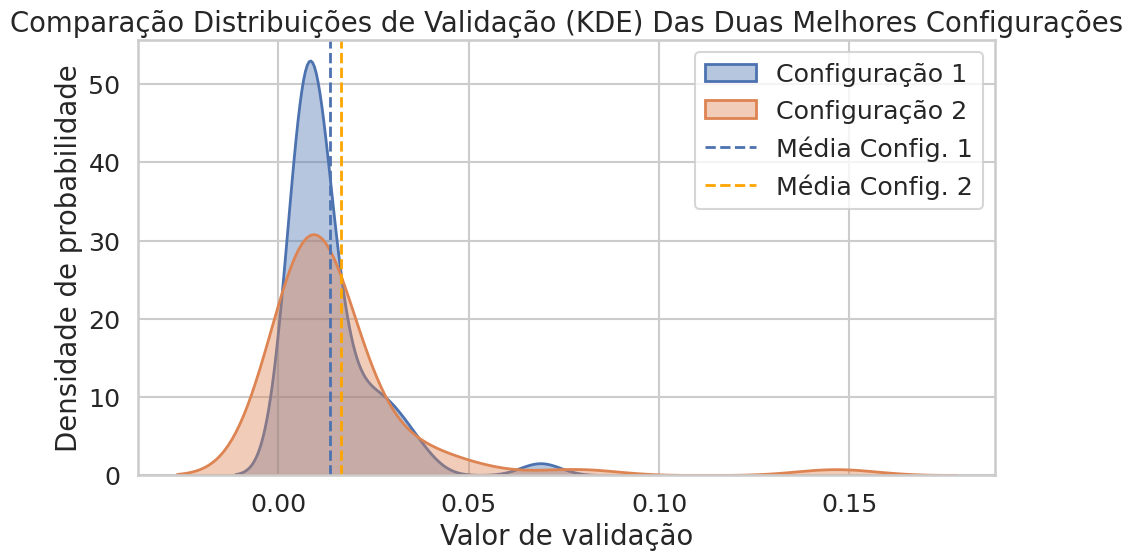

Teste de Wilcoxon Pareado
Estatística W: 609.0000
p-valor: 0.788753

Interpretação
Não há diferença estatisticamente significativa.
As duas configurações são estatisticamente equivalentes.

Médias:
Configuração 1: m = 0.013433, dv= 0.011362
Configuração 2: m = 0.016355, dv= 0.022835


In [17]:
loss_configuracao_1 = np.array(loss_configuracao_1)
loss_configuracao_2 = np.array(loss_configuracao_2)

sns.set_theme(
    style="whitegrid",
    context="talk",
    font_scale=1.1
)

plt.figure(figsize=(10, 6))

sns.kdeplot(
    loss_configuracao_1,
    fill=True,
    alpha=0.4,
    linewidth=2,
    label="Configuração 1"
)

sns.kdeplot(
    loss_configuracao_2,
    fill=True,
    alpha=0.4,
    linewidth=2,
    label="Configuração 2"
)

# Médias
plt.axvline(loss_configuracao_1.mean(), linestyle="--", linewidth=2, label="Média Config. 1")
plt.axvline(loss_configuracao_2.mean(), linestyle="--", linewidth=2, label="Média Config. 2", color = 'orange')

plt.xlabel("Valor de validação")
plt.ylabel("Densidade de probabilidade")
plt.title("Comparação Distribuições de Validação (KDE) Das Duas Melhores Configurações")
plt.legend()
plt.tight_layout()
plt.show()

# TESTE DE WILCOXON
stat, p_value = wilcoxon(loss_configuracao_1, loss_configuracao_2)

alpha = 0.05

print("Teste de Wilcoxon Pareado")
print(f"Estatística W: {stat:.4f}")
print(f"p-valor: {p_value:.6f}")

# INTERPRETAÇÃO
mean_1 = np.mean(loss_configuracao_1)
mean_2 = np.mean(loss_configuracao_2)

print("\nInterpretação")

if p_value < alpha:
    if mean_1 < mean_2:
        print("Diferença estatisticamente significativa.")
        print("Configuração 1 é estatisticamente MELHOR que a Configuração 2.")
    elif mean_2 < mean_1:
        print("Diferença estatisticamente significativa.")
        print("Configuração 2 é estatisticamente MELHOR que a Configuração 1.")
    else:
        print("Diferença estatisticamente significativa, mas as médias são iguais.")
else:
    print("Não há diferença estatisticamente significativa.")
    print("As duas configurações são estatisticamente equivalentes.")

print("\nMédias:")
print(f"Configuração 1: m = {mean_1:.6f}, dv= {np.std(loss_configuracao_1):.6f}")
print(f"Configuração 2: m = {mean_2:.6f}, dv= {np.std(loss_configuracao_2):.6f}")